In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gist_gray'
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from matplotlib.patches import Rectangle
from torchvision.datasets import CocoDetection
import os
import json
from PIL import Image
from statistics import mean
import matplotlib.patches as patches

In [2]:
all_detections = torch.load('all_detections_faster_new.pth', map_location=torch.device('cpu'))
all_targets = torch.load('all_targets_faster_new.pth', map_location=torch.device('cpu'))

In [3]:
# The all_targets_faster.pth file contains ground truth for 5000 images while the val2017 contains 5004 images
# apparently there were 4 duplicate images so the following code detects there names so we can delete them

# Path to your folder and JSON file
folder_path = 'val2017'
json_file_path = 'annotations_trainval2017/annotations/instances_val2017.json'

# Load the JSON file to get the list of images it contains
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)
    # Extract image filenames from the JSON file
    images_in_json = set([img['file_name'] for img in data['images']])

# Iterate over each file in the directory
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):  # Check if the file is a JPEG image
        if filename not in images_in_json:  # Check if the image is not listed in the JSON
            file_path = os.path.join(folder_path, filename)  # Full path to the file
            print(file_path)

In [4]:
def iou(boxA, boxB, ratio_x, ratio_y):
    # Find the coordinates of the intersection rectangle
    x = max(boxA[0]*ratio_x, boxB[0])
    y = max(boxA[1]*ratio_y, boxB[1])
    w = min(boxA[2]*ratio_x, boxB[2])
    h = min(boxA[3]*ratio_y, boxB[3])

    
    # Calculate the intersection area
    intersection = (w-x)*(h-y)
    # Calculate the prediction and ground-truth area
    predArea = (boxA[2]*ratio_x - boxA[0]*ratio_x)*(boxA[3]*ratio_y - boxA[1]*ratio_y)
    grndtruthArea = (boxB[2] - boxB[0])*(boxB[3] - boxB[1])
    
    # Calculate the IoU 
    iou = intersection/float(predArea + grndtruthArea - intersection)

    return iou

In [5]:
# Create a list which will contain 91 rows (one for each class) and store tp,fp and fn as 1,2 and 3 for each class
classes_list = [[] for _ in range(91)]

def calculate_precision_recall(detections, targets, iou_threshold, ratio_x, ratio_y):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    matched_ground_truth = set()
    matched_predictions = set()

    for det_idx,det in enumerate(detections['boxes']):
        if detections['scores'][det_idx] >= 0.1:
            det_label = detections['labels'][det_idx]
            det_matched = False

            for gt_idx, gt in enumerate(targets['boxes']):
                gt_label = targets['labels'][gt_idx]
                
                if iou(det, gt, ratio_x, ratio_y) >= iou_threshold:
                    if det_label==gt_label:
                        true_positives += 1
                        det_matched = True
                        matched_ground_truth.add(gt_idx)
                        classes_list[det_label].append(1)
                        matched_predictions.add(det_idx)
                        break
            if not det_matched:
                false_positives += 1
                classes_list[det_label].append(2)
                matched_predictions.add(det_idx)

    # Calculate the length of the list of scores with values greater than or equal to 0.1
    max_index = len(detections['scores'][detections['scores'] >= 0.1])

    # Create a set of all possible indexes
    all_indexes = set(range(max_index))
    
    # Find the indexes that are not contained in matched_detections
    unmatched_indexes = all_indexes - matched_predictions
  
    for index in unmatched_indexes:
        classes_list[detections['labels'][index]].append(3)
        
    false_negatives = len(targets['boxes']) - len(matched_ground_truth)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    # print("tp: ", true_positives, " fp: ", false_positives, " fn: ", false_negatives, " pr: ", precision, " rc: ", recall)
    
    return precision, recall 

In [6]:
# Code that will run calculate_precision_recall() function to find the precision and the recall of the fasterrcnn_resnet50_fpn model
precision = []
recall = []

folder_path = 'val2017'
idx = 0

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):  # Check if the file is a JPEG image
        file_path = os.path.join(folder_path, filename)  # Full path to the file
        with Image.open(file_path) as img:
            original_x, original_y = img.size
            ratio_x = round(original_x/800, 3)
            ratio_y = round(original_y/800, 3)

            # Call the calculate_precision_recall()
            curr_precision, curr_recall = calculate_precision_recall(all_detections[idx][0], all_targets[idx][0], 0.5, ratio_x, ratio_y)
            precision.append(curr_precision)
            recall.append(curr_recall)
            idx += 1

In [11]:
# Model precision and recall
model_precision = mean(precision)
model_recall = mean(recall)

# calculate F1 score
F1 = 2*(model_precision*model_recall/(model_precision+model_recall)) 

# We calculate the number of 1,2 and 3 (tp,fp and fn) for each class and then calculate the precision and recall for each class
lines_sums = [[] for _ in range(91)]

for i in range(len(classes_list)):
    for j in range(1,4):
        lines_sums[i].append(sum(1 for x in classes_list[i] if x == j))

precision_per_class = [[] for _ in range(91)]
for i in range(len(classes_list)):
    precision_per_class[i] = lines_sums[i][0]/(lines_sums[i][0]+lines_sums[i][1]) if (lines_sums[i][0]+lines_sums[i][1]) > 0 else 0

recall_per_class = [[] for _ in range(91)]
for i in range(len(classes_list)):
    recall_per_class[i] = lines_sums[i][0]/(lines_sums[i][0]+lines_sums[i][2]) if (lines_sums[i][0]+lines_sums[i][2]) > 0 else 0

# Calculate the mean average precision
mAP = sum(precision_per_class)/91

print("FASTERRCNN -> precision: ", model_precision, ", recall: ", model_recall, ", F1: ", F1, ", mAP: ", mAP)
# 800-800  FASTERRCNN -> precision:  0.3923620303778819 , recall:  0.8405953604158194 , F1:  0.5350025958750484 , mAP:  0.29295585232436494
# 800-1333 FASTERRCNN -> precision:  0.336563549413675 , recall:  0.8341935001579454 , F1:  0.4796197903120973 , mAP:  0.2575924808079601

fasterrcnn_time = torch.load('prediction_time_fastercnn.pth')
print("Average time for one image for FasterRCNN_ResNet50_FPN model: ", mean(fasterrcnn_time))

FASTERRCNN -> precision:  0.3923620303778819 , recall:  0.8405953604158194 , F1:  0.5350025958750484 , mAP:  0.29295585232436494
Average time for one image for FasterRCNN_ResNet50_FPN model:  0.09083282499313354


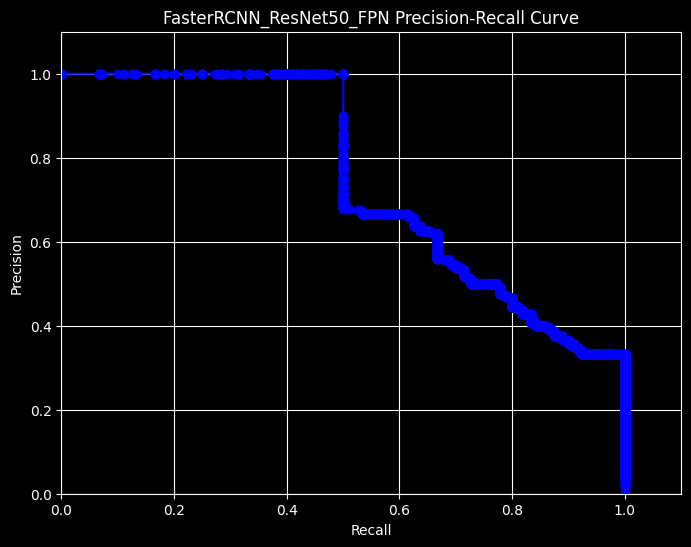

In [8]:
sorted_precision = sorted(precision, reverse=True)
sorted_recall = sorted(recall)

# Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(sorted_recall, sorted_precision, marker='o', linestyle='-', color='b')
plt.title('FasterRCNN_ResNet50_FPN Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.show()

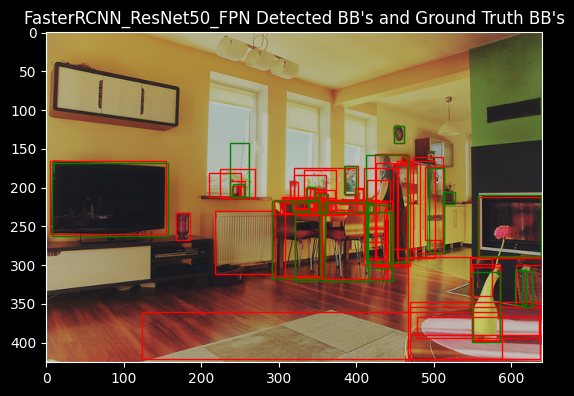

In [9]:
all_detections = torch.load('all_detections_faster_new.pth', map_location=torch.device('cpu'))
all_targets = torch.load('all_targets_faster_new.pth', map_location=torch.device('cpu'))

# Load the image
image_path = "val2017/000000000139.jpg"
image = Image.open(image_path)
original_x, original_y = image.size
ratio_x = round(original_x/800, 3)
ratio_y = round(original_y/800, 3)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Extract detection bounding boxes and draw them on the image
for box in all_detections[0][0]['boxes'][all_detections[0][0]['scores']>=0.1]:
    box = box.cpu().numpy()  # Assuming box is a torch tensor
    x_min, y_min, x_max, y_max = box
    width = (x_max - x_min) * ratio_x
    height = (y_max - y_min) * ratio_y
    rect = patches.Rectangle((x_min * ratio_x, y_min * ratio_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

for box in all_targets[0][0]['boxes']:
    # Extract target (ground truth) bounding boxes and draw them on the image
    box = box.cpu().numpy()  # Assuming box is a torch tensor
    x_min, y_min, x_max, y_max = box
    width = (x_max - x_min)
    height = (y_max - y_min)
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

plt.title('FasterRCNN_ResNet50_FPN Detected BB\'s and Ground Truth BB\'s')
plt.show()